# 使用RNN生成文本-shakespeare

这是学习tensorflow官网资料：https://tensorflow.google.cn/tutorials/sequences/text_generation 的笔记，通过RNN喂入莎士比亚的戏剧文本，尝试让电脑自己写出莎士比亚风格的文章。运行这个简单的例子需要强大的GPU，在我的笔记本上（MX 150只有2G显存）无法运行，如果只使用CPU需要较长的时间，需要有心理准备。可以在google colab上面运行测试，速度10x以上的提升。

这是一个many to many的示例。实际上，RNN可能有下图所示的几种模式(参见：http://karpathy.github.io/2015/05/21/rnn-effectiveness/)：
![diags](images/diags.jpeg)

@TODO

* 加入LSTM重新测试

## 启用eager execution

tensorflow 1.x默认没有启用eager execution，因此需要明确执行`enable_eager_execution()`打开这个开关。只有1.11以上版本才支持eager execution。

In [1]:
import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import os
import time

## 下载和观察数据

只要使用`tf.keras`中的方法下载的数据，默认都存放到了\$HOME/.keras/datasets目录下。下面是我的.keras/datasets目录的内容：
```shell
~/.keras/datasets$ ls
auto-mpg.data            cifar-10-batches-py.tar.gz  iris_test.csv
cifar-100-python         fashion-mnist               iris_training.csv
cifar-100-python.tar.gz  imdb.npz                    mnist.npz
cifar-10-batches-py      imdb_word_index.json        shakespeare.txt
```

In [2]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
print(path_to_file)

/home/subaochen/.keras/datasets/shakespeare.txt


这里不使用`tf.data.Dataset.TextlineDataset`？也许是因为需要进一步对文本进行分拆处理的缘故？

也没有使用`pandas`提供的方法？

有机会尝试使用`Dataset`或`pandas`改写这个部分。

In [3]:
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [4]:
# Take a look at the first 1000 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



## 文本向量化
文本向量化才能喂入RNN学习，需要三个步骤：
1. 构造文本字典vocab
1. 建立字典索引char2idx，将字典的每一个字符映射为数字
1. 使用char2idx将文本数字化（向量化）

<div class="alert alert-block alert-info">
<b>Tip:</b> 使用tf.data.Dataset.map方法可以更方便的处理文本向量化？不过就无法观察向量化文本的过程了。
</div>

In [5]:
# The unique characters in the file
vocab = sorted(set(text)) # sorted保证了集合的顺序
print ('{} unique characters'.format(len(vocab)))

65 unique characters


In [6]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
# vocab是有序集合，转化为数组后其下标自然就是序号，但是不如char2idx结构直观
# 如果模仿char2idx也很简单：idx2char = {i:u for i,u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])
text_as_int[:10]

array([18, 47, 56, 57, 58,  1, 15, 47, 58, 47])

各种方式观察一下向量化后的文本。这里没有使用matplotlib，没有太大意义。

In [7]:
# 取出char2idx前20个元素的奇怪写法。zip方法返回成对的元组，range(20)提供了序号。
for char,_ in zip(char2idx, range(20)):
    print('{:6s} ---> {:4d}'.format(repr(char), char2idx[char]))

'\n'   --->    0
' '    --->    1
'!'    --->    2
'$'    --->    3
'&'    --->    4
"'"    --->    5
','    --->    6
'-'    --->    7
'.'    --->    8
'3'    --->    9
':'    --->   10
';'    --->   11
'?'    --->   12
'A'    --->   13
'B'    --->   14
'C'    --->   15
'D'    --->   16
'E'    --->   17
'F'    --->   18
'G'    --->   19


In [8]:
# Show how the first 13 characters from the text are mapped to integers
print ('{} ---- characters mapped to int ---- > {}'.format(text[:13], text_as_int[:13]))

First Citizen ---- characters mapped to int ---- > [18 47 56 57 58  1 15 47 58 47 64 43 52]


## 构造训练数据（样本数据）
把数据喂给RNN之前，需要构造/划分好训练数据和验证数据。在这里，无需验证和测试数据，因此只需要划分好训练数据即可。下面的代码中，每次喂给RNN的训练数据是seq_length个字符。

但是，实际内部处理时，RNN还是要一个一个字符消化，即RNN的输入维度是len(vocab)，参见下图(出处：http://karpathy.github.io/2015/05/21/rnn-effectiveness/ )：
![charseq](http://softlab.sdut.edu.cn/blog/subaochen/wp-content/uploads/sites/4/2019/05/charseq.jpeg)

In [9]:
# The maximum length sentence we want for a single input in characters
# 每次喂入RNN的字符数。注意和后面的BATCH_SIZE的区别以及匹配
# 为了更好的观察数据，初始的时候seq_length可以设置为10，但是执行时要恢复为100或者
# 更大的数。当然，也可以测试不同的seq_length下的结果
seq_length = 100
examples_per_epoch = len(text)//seq_length

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
print(char_dataset)
for i in char_dataset.take(5):
    print(idx2char[i.numpy()])

<DatasetV1Adapter shapes: (), types: tf.int64>
Instructions for updating:
Colocations handled automatically by placer.
F
i
r
s
t


In [10]:
# sequences也是一个Dataset对象，但是经过了batch操作进行数据分组，每一个batch的数据
# 长度是seq_length+1（101）.sequences用来创建输入文本和目标文本（长度为seq_length）
# 注意：这里的batch操作和训练模型时的BATCH_SIZE没有关系，这里的batch操作纯粹
# 为了按照指定的尺寸切分数据
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
# repl函数的意义相当于Java的toString方法
# 注意，这里的item已经是tensor了，通过numpy()方法转化为numpy矩阵（向量）
# numpy数组（List）的强大之处：允许接受一个list作为索引参数，因此idx2char[item.numpy()]即为根据item
# 的数字为索引获得字符构造出一个字符串
for item in sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


## 创建输入文本和目标文本
输入文本即参数，目标文本相当于“标签”，预测文本将和目标文本比较以计算误差。
目标文本(target)和输入(input)文本的关系：目标文本和输入文本正好错开一个字符，即目标文本的第一个字符恰好是输入文本的第二个字符，以此类推。

注意下面的代码中，dataset的shape变化。

In [11]:
def split_input_target(chunk):
    input_text = chunk[:-1] # 不包括-1即最后一个字符，总共100个字符。这就是为什么chunk的长度是101的原因
    target_text = chunk[1:]
    return input_text, target_text
 
# 注意到，sequences已经是被batch过的了，因此这里的map是针对每个batch的数据来进行的
# 此时dataset的结果已经比较复杂了，所谓的nested structure of tensors
# print（dateset）的结果显示其shape为：shapes: ((10,), (10,))
# 即，dataset是一个tuple，tuple的每个数据又包含两个tuple，每个tuple是seq_length
# 长度的向量。其中第一个tuple是input_example，第二个tuple是target_example
dataset = sequences.map(split_input_target)
print(dataset)

<DatasetV1Adapter shapes: ((100,), (100,)), types: (tf.int64, tf.int64)>


input_example就是输入样本，target_example就是目标样本
可以看出，这里的输入样本和目标样本的尺寸都是seq_length，整个文本被batch_size
分割成了len(text_as_int)/seq_length组输入样本和目标样本

训练的时候是成对喂入输入样本和目标样本的：但是，其实内部还是一个字符一个字符来计算的，即先取输入样本的第一个字符作为x和目标样本的第一个字符作为y，然后依次处理完输入样本和目标样本的每一个字符，这个batch计算完毕。

In [12]:
# 将take的参数设为2能看的更清楚
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target data: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


在训练之前，先简单模拟一下预测First这个单词的过程：比如第一步（step 0），获得输入是19（F），预测值应该是47（i），以此类推。当然，这不是RNN。

In [13]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 18 ('F')
  expected output: 47 ('i')
Step    1
  input: 47 ('i')
  expected output: 56 ('r')
Step    2
  input: 56 ('r')
  expected output: 57 ('s')
Step    3
  input: 57 ('s')
  expected output: 58 ('t')
Step    4
  input: 58 ('t')
  expected output: 1 (' ')


## 使用批次重新构造训练数据

到目前为止，使用了如下的变量来表示文本的不同形态：
* text: 原始的文本
* text_as_int：向量化（数字化）的字符串
* sequences：按照seq_length+1切分的Dataset
* dataset：将每一个seqences划分为input_text和target_text的Dataset，此时的dataset其实比sequences大了一倍

到这个阶段，我们还需要将dataset中的（input_text，target_text）对进行shuffle处理。注意，这里的shuffle是以seq_length长度的input_text/target_text对为单位的，不是字符级别的shuffle。想一下dataset的数据结构。

另外，还需要进一步对数据进行batch处理以便迭代训练。

有点奇怪的是，fit方法为什么不能通过已经定义的batch_size自动确定步长？为什么一定要通过一个steps_per_epoch参数呢？steps_per_epoch也是通过batch_size计算出来的啊，按说应该都能够达到目的的。查阅了一下2.0.0-alpha0的文档，**这个限制已经取消了**，参见：https://www.tensorflow.org/alpha/tutorials/text/text_generation

In [14]:
# Batch size
# 这里的BATCH_SIZE的单位不是字符，因为此时的dataset是按照
# ((seq_length,),(seq_length))组织的
# 这里的32意味着，经过32次迭代，就需要遍历整个dataset，因此每次迭代需要喂入
# 的数据尺寸如steps_per_epoch所示。
BATCH_SIZE = 32

# steps_per_epoch说明每次喂入RNN的（input_example,target_example）的个数
# 使用model.fit时，如果传入的数据集是Dataset对象，必须显式声明steps_per_epoch参数
# 道理很简单，否则tensorflow不知道以多大的步长循环迭代给定的Dataset。因为传入fit函数
# 的Dataset只是经过了seq_length分组的input_text和target_text，并没有指定训练时
# 使用多大的步长来迭代整个Dataset。
# steps_per_epoch = len(text)//seq_length//BATCH_SIZE
steps_per_epoch = examples_per_epoch//BATCH_SIZE

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

# 
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset

<DatasetV1Adapter shapes: ((32, 100), (32, 100)), types: (tf.int64, tf.int64)>

# 创建模型

模型分为三层：
1. 嵌入层（layers.Embedding)。关于嵌入的概念可参考：https://tensorflow.google.cn/guide/embedding 。简单的说，嵌入层的作用是将输入(本例是输入字符的索引)映射为一个高维度向量（dense vector），其好处是可以借助于向量的方法，比如欧氏距离或者角度来度量两个向量的相似性。对于文本而言，就是两个词的相似度。
2. GRU层（Gated Recurrent Unit）
3. 全链接层

# 设置模型参数，实例化模型
为了能够在笔记本电脑上运行，特意调小了embedding_dim和rnn_units两个参数

In [15]:
# Length of the vocabulary in chars
# 这是输入层和输出层的维度。
# 每一个字符都需要进行one-hot编码，因此每一个输入都是vocab_size维度的向量
# 同样的，每一个预测的输出也是vocab_size维度的向量
vocab_size = len(vocab)

# The embedding dimension 
#embedding_dim = 256
embedding_dim = 256

# Number of RNN units
#rnn_units = 1024
rnn_units = 512

In [16]:
if tf.test.is_gpu_available():
  rnn = tf.keras.layers.CuDNNGRU
else:
  import functools
  rnn = functools.partial(
    tf.keras.layers.GRU, recurrent_activation='sigmoid')

In [17]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                              batch_input_shape=[batch_size, None]),
    # 替换rnn为LSTM
    tf.keras.layers.LSTM(rnn_units,
        return_sequences=True, 
        recurrent_initializer='glorot_uniform',
        stateful=True),
    tf.keras.layers.Dense(vocab_size) # 这里不需要激活函数？softmax？
  ])
  return model

In [18]:
model = build_model(
  vocab_size = len(vocab), 
  embedding_dim=embedding_dim, 
  rnn_units=rnn_units, 
  batch_size=BATCH_SIZE)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 256)           16640     
_________________________________________________________________
lstm (LSTM)                  (32, None, 512)           1574912   
_________________________________________________________________
dense (Dense)                (32, None, 65)            33345     
Total params: 1,624,897
Trainable params: 1,624,897
Non-trainable params: 0
_________________________________________________________________


## 先测试一下模型


In [19]:
# input_example_batch是dataset的一个batch，这里是32个seq_length的input_text
# 由于喂入的数据的shape是(32,seq_length)，输出example_batch_prediction的
# shape自然就是(32,seq_length,65)
for input_example_batch, target_example_batch in dataset.take(1): 
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(32, 100, 65) # (batch_size, sequence_length, vocab_size)


<font color="red">这是为什么使用random.categorical抽取数据？</font>

In [20]:
# 检查第0批数据？
sampled_indices = tf.random.categorical(example_batch_predictions[0], 
                                        num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([ 2, 64, 63, 27, 62,  3,  6, 19, 48, 57, 26, 27, 36, 21, 15,  9, 18,
       22,  7, 44, 11, 35, 37, 26, 11, 47, 15, 15, 31, 37, 36, 61, 25,  5,
       23, 61, 26, 24, 64, 39, 12, 20, 13, 58, 54, 31, 32,  0, 57, 39,  5,
       53, 15, 62, 43, 43, 51,  0, 63,  0,  6, 40,  0, 57, 37, 59,  9, 62,
       42, 22, 61, 28, 23, 10, 36, 38,  5, 29, 13, 37, 47, 27, 42, 63, 13,
       12, 54, 53, 62, 36, 58, 43, 24, 56, 37, 23, 47, 47, 22,  3])

In [21]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0].numpy()])))
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 'grave elders, to desire\nThe present consul, and last general\nIn our well-found successes, to report\n'
Next Char Predictions: 
 "!zyOx$,GjsNOXIC3FJ-f;WYN;iCCSYXwM'KwNLza?HAtpST\nsa'oCxeem\ny\n,b\nsYu3xdJwPK:XZ'QAYiOdyA?poxXteLrYKiiJ$"


# 定义优化器和损失函数

In [22]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 65)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.1742725


In [23]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

恢复checkpoint
如何检测checkoutpoint是否存在？

In [24]:
ckpt = tf.train.latest_checkpoint(checkpoint_dir)
if ckpt != None:
  print("load model from checkpoint")
  model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=BATCH_SIZE)
  model.load_weights(ckpt)
  model.build(tf.TensorShape([1, None]))
  model.summary()

In [25]:
model.compile(
    optimizer = 'adam',
    loss = loss)

In [26]:
EPOCHS = 3

In [27]:
history = model.fit(dataset.repeat(), epochs=EPOCHS, 
                    steps_per_epoch=steps_per_epoch, 
                    callbacks=[checkpoint_callback])

Epoch 1/3


/home/subaochen/anaconda3/envs/tf1-cpu/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


347/348 [============================>.] - ETA: 1s - loss: 2.3692WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7f79a03ee828>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.
348/348 [==============================] - 574s 2s/step - loss: 2.3678
Epoch 2/3
347/348 [============================>.] - ETA: 1s - loss: 1.7566WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7f79a03ee828>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizer

# 绘制训练图表

In [28]:
import matplotlib.pyplot as plt

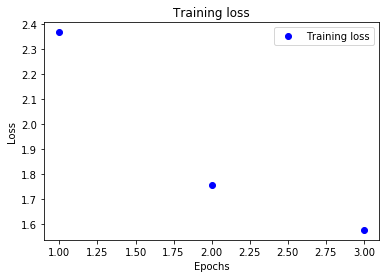

In [29]:
history_dict = history.history
history_dict.keys()
loss=history_dict['loss']
epochs = range(1, len(loss) + 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 产生文本

## 恢复到最新的checkpoint

这个步骤是不是应该放在训练之前，以便积累训练的成果？

In [30]:
ckpt = tf.train.latest_checkpoint(checkpoint_dir)
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(ckpt)
model.build(tf.TensorShape([1, None]))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            16640     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 512)            1574912   
_________________________________________________________________
dense_1 (Dense)              (1, None, 65)             33345     
Total params: 1,624,897
Trainable params: 1,624,897
Non-trainable params: 0
_________________________________________________________________


## 进行预测

model可以接受任意长度的字符串作为参数。实际上，无论多长的字符串，model都是需要一个一个进行处理的，最终给出的是每个输入字符对应的预测字符。参考下图了解shape在各个过程的变化（出处：https://www.tensorflow.org/tutorials/sequences/text_generation）：
![](http://softlab.sdut.edu.cn/blog/subaochen/wp-content/uploads/sites/4/2019/05/text_generation_training.png)

## 如何观察预测结果？
可以设置num_generate为一个**小的数字**，比如3，然后在后面的三个循环中，逐步打印出input_eval, prediction_id等的值，注意观察在不同的阶段各个向量的**维度**和**数值**的变化。

In [31]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 1000

  # Converting our start string to numbers (vectorizing) 
  input_eval = [char2idx[s] for s in start_string]
  # 构造维度合适的输入数据：[batch_size,seq_length]
  # 这里batch_size=1，因此只需要将start_string扩展一维即可
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      # why not call model.predict()?
      predictions = model(input_eval)
      #print("predictions.shape:",predictions.shape)
      
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a multinomial distribution to predict the word returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      #print("predicted_id:",predicted_id)
      
      # We pass the predicted word as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)
      
      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

print(generate_text(model, start_string=u"First:"))

First:
Set me in my life, shill saved we cannot pirture houses,
From Lord unnour forth mine readfround placmif:
She stratue here again; desembred, so is ntwire gronation.
The lave,
Ther away the prayers.

MENENIUS:
Now, hou werpho thy plafe, made as honest the comes:
Becond eemill. Reventant and drave us.
How not thou art of Namicient detraced prevends,
Upon he gids trual by a man farewence to due,
Or, look tho amfition Tuurssly should in:
Our worthing reture in the fault him myself
As commonian dried, command slamen-w
Now he
wor good our base sol, nither command some forsuar: he has doy wit
such grong, his comfort o' thair prest, brave
The ablickle dreigns.

MORCALA: I love this dead, and fallow
For Chimaifor petchantom gentles wild ready,
that if through beack in none revongering friends,
Ceftrence is a bleasure of life, trange, drance'd
The grave dain stirst of the sunks te and Gap's Hancy'd dead,
Befuir is than we preaso, nos. What, wen it it
Of thing twong of your reportity,
Alass

# 后记

从这个简单的RNN的示例中，可以学到：
* RNN很强大，只是简单的一层LSTM（RNN）和为数不多的几次迭代训练，RNN就能够学会简单的语法结构甚至比较短的单词构成。馈入更多的训练样本和更多的迭代次数，RNN应该能够学会更多的语法特征和更多的词汇。
* RNN的训练很消耗资源。
* RNN能够解决很多问题，这里演示的是many to many类型的。
* RNN并不限制输入数据的大小，也就是说，RNN的input_example可以是任意长度的。
* 无论一次馈入多少数据，显然RNN也是一个一个进行计算和处理的；只是，在定义了`batch_size`的前提下，RNN会按照指定的`batch_size`一次汇总给出计算结果，这就是为什么输入数据要组织为`(batch_size, seq_length)`的原因：只有在输入的时候确定了`batch_size`，输出的时候才能够按照这个batch_size汇总结果为`(batch_size, vcab_size)`。
* 使用`tf.random.categorical`获得预测结果：预测结果显然是按照batch_size给出的概率分布，可以通过`tf.random.categorical`函数方便的获得最大概率项的索引，即预测值。

# 进一步的练习目标
* 切分数据集为train_set, cross_validation_set, test_set，并监控loss, val_loss, test_loss的变化
* 启用earlyStopping
* 换其他数据集测试一下，比如全唐诗？全宋词？
* 将字典单位换位“单词”，即不是以字符为单位，而是以单词为单位切分原始文本
* 重新组织程序，更加模块化，使得持续训练和测试更加方便
* 将这里学到的技术迁移到many to one的应用场景，比如金融领域的股价走势预测；以及one to many的应用场景，比如？